In [16]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms


In [17]:
class ImageDenoisingDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None, augment=False):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.file_names = sorted(os.listdir(input_dir))
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        input_path = os.path.join(self.input_dir, file_name)
        target_path = os.path.join(self.target_dir, file_name)
        
        input_image = Image.open(input_path).convert("RGB")
        target_image = Image.open(target_path).convert("RGB")
        
        # Apply augmentation
        if self.augment:
            augmentation = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomHorizontalFlip(),  # Randomly flip images
                transforms.RandomRotation(15),     # Rotate images up to 15 degrees
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                ])
            input_image = augmentation(input_image)
            target_image = augmentation(target_image)

        # Apply general transformations
        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image


In [18]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

dataset = ImageDenoisingDataset(
    input_dir="/home/vamsi/cv/project/new_set/original_image",
    target_dir="/home/vamsi/cv/project/new_set/inpainted_image",
    augment=True
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check augmented samples
for inputs, targets in dataloader:
    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)
    break


Inputs shape: torch.Size([4, 3, 256, 256])
Targets shape: torch.Size([4, 3, 256, 256])


In [19]:
from torch.utils.data import random_split, DataLoader
# Split dataset into training and validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define separate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [20]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",    
    in_channels=3,                 
    classes=3                     
)

print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [21]:
# Freeze the encoder weights
for param in model.encoder.parameters():
    param.requires_grad = False

# Send model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [22]:
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [23]:
# Training loop
epochs = 50
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/50, Loss: 0.5908
Epoch 2/50, Loss: 0.4402
Epoch 3/50, Loss: 0.3184
Epoch 4/50, Loss: 0.2346
Epoch 5/50, Loss: 0.1730
Epoch 6/50, Loss: 0.1315
Epoch 7/50, Loss: 0.1007
Epoch 8/50, Loss: 0.0768
Epoch 9/50, Loss: 0.0635
Epoch 10/50, Loss: 0.0565
Epoch 11/50, Loss: 0.0506
Epoch 12/50, Loss: 0.0425
Epoch 13/50, Loss: 0.0429
Epoch 14/50, Loss: 0.0362
Epoch 15/50, Loss: 0.0320
Epoch 16/50, Loss: 0.0341
Epoch 17/50, Loss: 0.0318
Epoch 18/50, Loss: 0.0303
Epoch 19/50, Loss: 0.0285
Epoch 20/50, Loss: 0.0257
Epoch 21/50, Loss: 0.0248
Epoch 22/50, Loss: 0.0236
Epoch 23/50, Loss: 0.0228
Epoch 24/50, Loss: 0.0272
Epoch 25/50, Loss: 0.0269
Epoch 26/50, Loss: 0.0262
Epoch 27/50, Loss: 0.0232
Epoch 28/50, Loss: 0.0221
Epoch 29/50, Loss: 0.0244
Epoch 30/50, Loss: 0.0228
Epoch 31/50, Loss: 0.0224
Epoch 32/50, Loss: 0.0209
Epoch 33/50, Loss: 0.0201
Epoch 34/50, Loss: 0.0217
Epoch 35/50, Loss: 0.0197
Epoch 36/50, Loss: 0.0226
Epoch 37/50, Loss: 0.0230
Epoch 38/50, Loss: 0.0211
Epoch 39/50, Loss: 0.

In [ ]:
# Training loop
epochs = 100
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/100, Loss: 1.6422
Epoch 2/100, Loss: 1.6467
Epoch 3/100, Loss: 1.6442
Epoch 4/100, Loss: 1.6493
Epoch 5/100, Loss: 1.6496
Epoch 6/100, Loss: 1.6540
Epoch 7/100, Loss: 1.6439
Epoch 8/100, Loss: 1.6480
Epoch 9/100, Loss: 1.6452
Epoch 10/100, Loss: 1.6498
Epoch 11/100, Loss: 1.6476
Epoch 12/100, Loss: 1.6374
Epoch 13/100, Loss: 1.6426
Epoch 14/100, Loss: 1.6517
Epoch 15/100, Loss: 1.6447
Epoch 16/100, Loss: 1.6564
Epoch 17/100, Loss: 1.6538
Epoch 18/100, Loss: 1.6430
Epoch 19/100, Loss: 1.6421
Epoch 20/100, Loss: 1.6450
Epoch 21/100, Loss: 1.6401
Epoch 22/100, Loss: 1.6415
Epoch 23/100, Loss: 1.6510
Epoch 24/100, Loss: 1.6459
Epoch 25/100, Loss: 1.6495
Epoch 26/100, Loss: 1.6505
Epoch 27/100, Loss: 1.6464
Epoch 28/100, Loss: 1.6401
Epoch 29/100, Loss: 1.6481
Epoch 30/100, Loss: 1.6451
Epoch 31/100, Loss: 1.6443
Epoch 32/100, Loss: 1.6456
Epoch 33/100, Loss: 1.6481
Epoch 34/100, Loss: 1.6435
Epoch 35/100, Loss: 1.6474
Epoch 36/100, Loss: 1.6463
Epoch 37/100, Loss: 1.6474
Epoch 38/1

In [24]:
model.eval()

val_loss = 0.0
criterion = nn.MSELoss()  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        val_loss += loss.item()

# Calculate average validation loss
val_loss /= len(val_loader)
print(f"Validation Loss: {val_loss:.4f}")


Validation Loss: 0.0129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39695382..0.93047345].


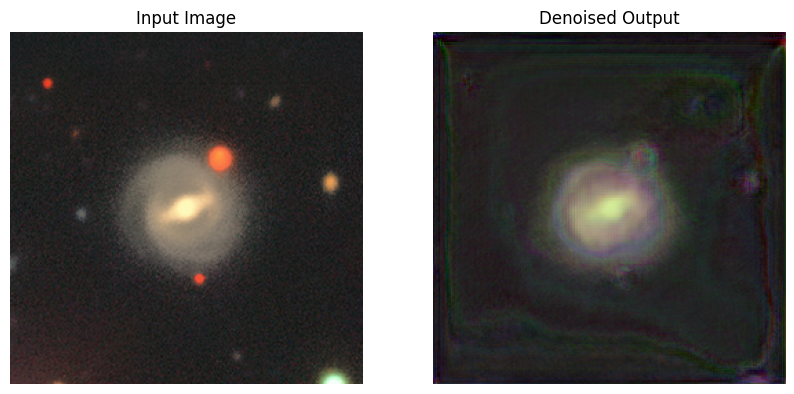

In [25]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_image_path = "/home/vamsi/cv/project/dc/5/image_7945.png"
test_image = Image.open(test_image_path).convert("RGB")

input_image = transform(test_image).unsqueeze(0)  # Add batch dimension (1, 3, 256, 256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_image = input_image.to(device)

model.eval()

with torch.no_grad():
    output = model(input_image)

output = output.cpu().squeeze(0)  # Shape: [3, 256, 256]

output_image = output.permute(1, 2, 0).numpy()  # Shape: [256, 256, 3]
output_image = (output_image * 0.5 + 0.5)  # Denormalize back to [0, 1]

plt.figure(figsize=(10, 5))

# Input image
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(test_image)
plt.axis('off')

# Output (denoised) image
plt.subplot(1, 2, 2)
plt.title("Denoised Output")
plt.imshow(output_image)
plt.axis('off')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32228047..0.7454889].


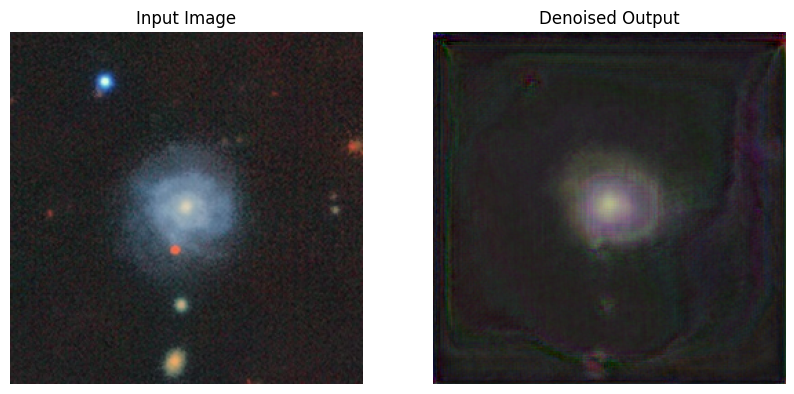

In [32]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_image_path = "/home/vamsi/cv/project/new_set/original_image/1.jpg"
test_image = Image.open(test_image_path).convert("RGB")

input_image = transform(test_image).unsqueeze(0)  # Add batch dimension (1, 3, 256, 256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_image = input_image.to(device)

model.eval()

with torch.no_grad():
    output = model(input_image)

output = output.cpu().squeeze(0)  # Shape: [3, 256, 256]

output_image = output.permute(1, 2, 0).numpy()  # Shape: [256, 256, 3]
output_image = (output_image * 0.5 + 0.5)  # Denormalize back to [0, 1]

plt.figure(figsize=(10, 5))

# Input image
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(test_image)
plt.axis('off')

# Output (denoised) image
plt.subplot(1, 2, 2)
plt.title("Denoised Output")
plt.imshow(output_image)
plt.axis('off')

plt.show()
